# Raster Mosaicing and Clipping

## Introduction

The [`rioxarray`](https://corteva.github.io/rioxarray/stable/) extension adds support for working with raster data using XArray. In this tutorial ,we explore basic raster processing of reading, mosaicing and clipping raster data using XArray.

## Overview of the Task

We will work with elevation data for Sri Lanka in the form of individual SRTM tiles, merge them and clip the resulting mosaic to the country boundary. We will also save the resulting raster as a Cloud-optimized GeoTIFF (COG).


**Input Layers**:
* `[NXXEYYY].SRTMGL1.hgt.zip`: Zipped raster tiles in SRTM HGT format
* `ne_10m_admin_0_countries.zip`: A shapefile of country boundaries

**Output**:
* `clipped.tif`: A clipped and mosaiced GeoTiff file for Sri Lanka.

**Data Credit**:
- NASA Shuttle Radar Topography Mission Global 1 arc second provided by The Land Processes Distributed Active Archive Center (LP DAAC). Downloaded using 30-Meter SRTM Tile Downloader
- Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [3]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray

In [9]:
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

In [5]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [6]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

srtm_tiles = [
  'N05E080.SRTMGL1.hgt.zip',
  'N06E079.SRTMGL1.hgt.zip',
  'N06E080.SRTMGL1.hgt.zip',
  'N06E081.SRTMGL1.hgt.zip',
  'N07E079.SRTMGL1.hgt.zip',
  'N07E080.SRTMGL1.hgt.zip',
  'N07E081.SRTMGL1.hgt.zip',
  'N08E079.SRTMGL1.hgt.zip',
  'N08E080.SRTMGL1.hgt.zip',
  'N08E081.SRTMGL1.hgt.zip',
  'N09E080.SRTMGL1.hgt.zip'
]

shapefile = 'ne_10m_admin_0_countries_ind.zip'

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

for tile in srtm_tiles:
  url = '{}/{}'.format(data_url, tile)
  download(url)

download('{}/{}'.format(data_url,shapefile))

Downloaded data/N05E080.SRTMGL1.hgt.zip
Downloaded data/N06E079.SRTMGL1.hgt.zip
Downloaded data/N06E080.SRTMGL1.hgt.zip
Downloaded data/N06E081.SRTMGL1.hgt.zip
Downloaded data/N07E079.SRTMGL1.hgt.zip
Downloaded data/N07E080.SRTMGL1.hgt.zip
Downloaded data/N07E081.SRTMGL1.hgt.zip
Downloaded data/N08E079.SRTMGL1.hgt.zip
Downloaded data/N08E080.SRTMGL1.hgt.zip
Downloaded data/N08E081.SRTMGL1.hgt.zip
Downloaded data/N09E080.SRTMGL1.hgt.zip
Downloaded data/ne_10m_admin_0_countries_ind.zip


## Procedure

Iterate through the zipped files and read them using rioxarray. rioxarray uses GDAL to read raster datasets, and can read zipped SRTM files directly. We also specify `mask_and_scale=False` so the nodata values from the input rasters is preserved and not set to NaN.

In [7]:
datasets = []
for tile in srtm_tiles:
  zipfile = os.path.join(data_folder, tile)
  datasets.append(rxr.open_rasterio(zipfile, mask_and_scale=False))

Now that we have a list of XArray datasets, we can use the `merge_arrays` function from `rioxarray` to merge them into a mosaic.

In [27]:
merged = merge_arrays(datasets)
merged

<xarray.DataArray (band: 1, y: 18001, x: 10801)> Size: 389MB
array([[[-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        ...,
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768]]],
      dtype=int16)
Coordinates:
  * x            (x) float64 86kB 79.0 79.0 79.0 79.0 ... 82.0 82.0 82.0 82.0
  * y            (y) float64 144kB 10.0 10.0 9.999 9.999 ... 5.001 5.001 5.0 5.0
    spatial_ref  int64 8B 0
  * band         (band) int64 8B 1
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

Next, we read the Natural Earth administrative regions shapefile.

In [11]:
shapefile_path = os.path.join(data_folder, shapefile)
boundaries_gdf = gpd.read_file(shapefile_path)

For this tutorial, we want to clip the raster to the boundary of Sri Lanka. We filter the dataframe using the ADM0_A3 column and extract the geometry.

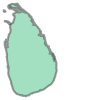

In [26]:
srilanka = boundaries_gdf[boundaries_gdf['ADM0_A3'] == 'LKA']
geometry = srilanka.geometry.union_all()
geometry

Now we clip the merged raster using the `clip` function from `rioxarray`. For XArray datasets, we can use the `rio` accessor to run the `rioxarray` functions.

In [13]:
clipped = merged.rio.clip(geometry)

Our clipped data has -32768 as nodata. We mask these and [encode the correct nodata](https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html#Manually-masking-data) value.

In [14]:
clipped = clipped.where(clipped != clipped.rio.nodata)
clipped.rio.write_nodata(clipped.rio.nodata, encoded=True, inplace=True)
clipped

<xarray.DataArray (band: 1, y: 14061, x: 8045)> Size: 452MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 64kB 79.66 79.66 79.66 79.66 ... 81.89 81.89 81.89
  * y            (y) float64 112kB 9.829 9.829 9.829 9.829 ... 5.924 5.924 5.924
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Last step is to save the results to disk as GeoTiff files. We use [Cloud-Optimized GeoTIFF (COG)](https://gdal.org/drivers/raster/cog.html) driver and specify additional GDAL [compression options](https://rasterio.readthedocs.io/en/stable/topics/image_options.html#creation-options).

In [24]:
output_dem = 'clipped.tif'
output_dem_path = os.path.join(output_folder, output_dem)
clipped.rio.to_raster(
    output_dem_path, driver='COG', dtype='int16',
    compress='DEFLATE', predictor='YES')